<a href="https://colab.research.google.com/github/swaingotnochill/Automation/blob/main/TrafficSignRecognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1XQvqXE-cy-seaMojF0EeP0QoOVtV9NeL')

     |████████████████████████████████| 71kB 5.0MB/s 


In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import os


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meviole
Your Kaggle Key: ··········


  0%|          | 0.00/612M [00:00<?, ?B/s]

100%|██████████| 612M/612M [00:25<00:00, 25.2MB/s]


In [ ]:
train_data_path = './gtsrb-german-traffic-sign/Train'
classes = (os.listdir(train_data_path))
len(classes)

43

In [ ]:
print(os.listdir(train_data_path + '/1')[:10])

['00001_00064_00006.png', '00001_00036_00006.png', '00001_00039_00002.png', '00001_00026_00027.png', '00001_00065_00011.png', '00001_00026_00003.png', '00001_00000_00012.png', '00001_00030_00019.png', '00001_00004_00029.png', '00001_00000_00027.png']


In [ ]:
test_dir_path ='../input/gtsrb-german-traffic-sign/Test'


In [ ]:
Data_dir = './'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import torchvision.transforms as tt

In [92]:
img_size = 32
batch_size = 5
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

train_ds = ImageFolder(train_data_path, transform=tt.Compose([
    tt.Resize(img_size),
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)

]))

In [82]:
len(train_ds)

39209

In [83]:
import torch.utils.data as data

In [84]:
val_size = 8000
train_size = len(train_ds) - val_size
train_data, val_data = data.random_split(train_ds, [train_size, val_size])

In [85]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size=val_size, num_workers=4, pin_memory=True)

In [86]:
def denorm(img_tensor):
    return img_tensor*stats[0][1] + stats[0][0]

In [87]:
from torchvision.utils import make_grid

In [88]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
        

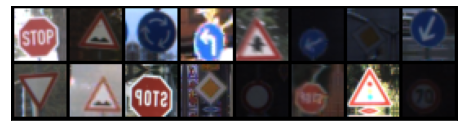

In [89]:
show_batch(train_dl)

In [90]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [91]:
device = get_default_device()
device

device(type='cuda')

In [72]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [73]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [74]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print('Epoch [{}], last_lr: {:.5f}, train_loss:{:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [75]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [76]:
model =to_device(ResNet9(3, 43), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [77]:
from tqdm.notebook import tqdm

In [78]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [79]:
!nvidia-smi

Wed Jan 13 14:10:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    24W /  75W |   6969MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [80]:
history = [evaluate(model, val_dl)]
history

RuntimeError: ignored

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_fun = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr,model,  train_dl, val_dl, grad_clip= grad_clip, weight_decay = weight_decay, opt_func= opt_fun)


Epoch [0], last_lr: 0.00279, train_loss:1.4836, val_loss: 0.6080, val_acc: 0.8090


RuntimeError: ignored

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='TrafficSignRecognization', environment=None)